In [135]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from pmdarima import auto_arima
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [136]:
#Prepare Data
aapl_dat = yf.download('AAPL', start='2015-01-01', end='2024-06-01', interval='1d', actions=True)

aapl_dat["Dividends"] = aapl_dat["Dividends"].fillna(0)
aapl_dat["Stock Splits"] = aapl_dat["Stock Splits"].fillna(0)
aapl_dat["MA_50"] = aapl_dat["Close"].rolling(window=50).mean()
aapl_dat["Volatility_50"] = aapl_dat["Close"].rolling(window=50).std()
aapl_dat["Lag1"] = aapl_dat["Close"].shift(1)
aapl_dat["Lag2"] = aapl_dat["Close"].shift(2)
aapl_dat["Lag3"] = aapl_dat["Close"].shift(3)
aapl_dat["Lag4"] = aapl_dat["Close"].shift(4)
aapl_dat["Lag5"] = aapl_dat["Close"].shift(5)
aapl_dat = aapl_dat.dropna()

feats = ["Volume", "Dividends", "Stock Splits", "MA_50", "Volatility_50", "Lag1", "Lag2", "Lag3", "Lag4", "Lag5"]
target = "Close"

X = aapl_dat[feats]
y = aapl_dat[target]

[*********************100%***********************]  1 of 1 completed


In [137]:
#Split Data
train_dat = aapl_dat[aapl_dat.index < "2022-01-01"]
test_dat = aapl_dat[aapl_dat.index >= "2022-01-01"]

X_train = train_dat[feats]
y_train = train_dat[target]
X_test = test_dat[feats]
y_test = test_dat[target]

In [138]:
#Catboost Hyperparameter Tuning and Fit Model
param_grid = {
    "iterations": [10, 20],
    "depth": [4, 6, 8, 10],
    "learning_rate": [0.01, 0.1, 0.3],
    "l2_leaf_reg": [3, 5],
}

cb = CatBoostRegressor(random_state=1, silent=True, loss_function="RMSEWithUncertainty")
rs = RandomizedSearchCV(cb, param_grid, n_iter=10, n_jobs=-1, cv=5, verbose=1, random_state=1)
rs.fit(X_train, y_train)
best_model = rs.best_estimator_

y_pred = best_model.predict(X_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


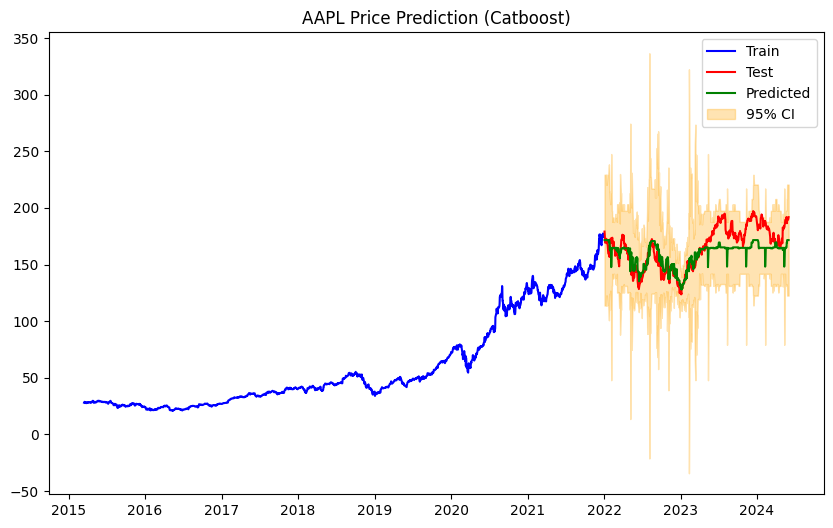

In [139]:
#Plot
preds = y_pred[:,0]
preds_std = y_pred[:,1]
pred_lower = preds - 1.96 * preds_std
pred_upper = preds + 1.96 * preds_std
plt.figure(figsize=(10, 6))
plt.plot(train_dat.index, train_dat[target], label="Train", color="blue")
plt.plot(test_dat.index, y_test, label="Test", color="red")
plt.plot(test_dat.index, preds, label="Predicted", color="green")
plt.fill_between(test_dat.index, pred_lower, pred_upper, color="orange", alpha=0.3, label="95% CI")
plt.title("AAPL Price Prediction (Catboost)")
plt.legend()
plt.show()